In [1]:
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
import azureml
from azureml.core import Workspace

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.19.0


## Workspace

In [3]:
ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep = '\n')

Workspace name: is_comp
Azure region: uksouth
Subscription id: 8c336e5e-092b-4c3d-bf2c-ef37a53a0711
Resource group: is_2021


## Experiment

In [4]:
from azureml.core import Experiment

script_folder = './tf-mnist'
os.makedirs(script_folder, exist_ok=True)

exp = Experiment(workspace=ws, name='tf-mnist')

## Dataset

In [5]:
import urllib.request

data_folder = os.path.join(os.getcwd(), 'data')
os.makedirs(data_folder, exist_ok=True)

urllib.request.urlretrieve('https://azureopendatastorage.blob.core.windows.net/mnist/train-images-idx3-ubyte.gz',
                           filename=os.path.join(data_folder, 'train-images-idx3-ubyte.gz'))
urllib.request.urlretrieve('https://azureopendatastorage.blob.core.windows.net/mnist/train-labels-idx1-ubyte.gz',
                           filename=os.path.join(data_folder, 'train-labels-idx1-ubyte.gz'))
urllib.request.urlretrieve('https://azureopendatastorage.blob.core.windows.net/mnist/t10k-images-idx3-ubyte.gz',
                           filename=os.path.join(data_folder, 't10k-images-idx3-ubyte.gz'))
urllib.request.urlretrieve('https://azureopendatastorage.blob.core.windows.net/mnist/t10k-labels-idx1-ubyte.gz',
                           filename=os.path.join(data_folder, 't10k-labels-idx1-ubyte.gz'))

('/Users/yoshioschermer/Google Drive/School/2020-2021/Intelligent Systems/intelligent_systems_assignments/MachineLearningNotebooks/practicum/data/t10k-labels-idx1-ubyte.gz',
 <http.client.HTTPMessage at 0x7f885085aee0>)

In [6]:
from azureml.core.dataset import Dataset
web_paths = ['https://azureopendatastorage.blob.core.windows.net/mnist/train-images-idx3-ubyte.gz',
             'https://azureopendatastorage.blob.core.windows.net/mnist/train-labels-idx1-ubyte.gz',
             'https://azureopendatastorage.blob.core.windows.net/mnist/t10k-images-idx3-ubyte.gz',
             'https://azureopendatastorage.blob.core.windows.net/mnist/t10k-labels-idx1-ubyte.gz'
            ]
dataset = Dataset.File.from_files(path = web_paths)

In [7]:
dataset_registered = False
try:
    temp = Dataset.get_by_name(workspace = ws, name = 'mnist-dataset')
    dataset_registered = True
except:
    print("The dataset mnist-dataset is not registered in workspace yet.")

if not dataset_registered:
    dataset = dataset.register(workspace = ws,
                               name = 'mnist-dataset',
                               description='training and test dataset',
                               create_new_version=True)
# list the files referenced by dataset
dataset.to_path()

['/https%3A/%2Fazureopendatastorage.blob.core.windows.net/mnist/train-images-idx3-ubyte.gz',
 '/https%3A/%2Fazureopendatastorage.blob.core.windows.net/mnist/train-labels-idx1-ubyte.gz',
 '/https%3A/%2Fazureopendatastorage.blob.core.windows.net/mnist/t10k-images-idx3-ubyte.gz',
 '/https%3A/%2Fazureopendatastorage.blob.core.windows.net/mnist/t10k-labels-idx1-ubyte.gz']

## Resources

In [8]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# choose a name for your cluster
cluster_name = "gpu-cluster"

try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing compute target')
except ComputeTargetException:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_NC6', 
                                                           max_nodes=4)

    # create the cluster
    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)

# can poll for a minimum number of nodes and for a specific timeout. 
# if no min node count is provided it uses the scale settings for the cluster
compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)

# use get_status() to get a detailed status for the current cluster. 
print(compute_target.get_status().serialize())

Found existing compute target
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned
{'currentNodeCount': 0, 'targetNodeCount': 0, 'nodeStateCounts': {'preparingNodeCount': 0, 'runningNodeCount': 0, 'idleNodeCount': 0, 'unusableNodeCount': 0, 'leavingNodeCount': 0, 'preemptedNodeCount': 0}, 'allocationState': 'Steady', 'allocationStateTransitionTime': '2021-01-02T21:08:28.160000+00:00', 'errors': None, 'creationTime': '2021-01-02T16:17:32.618519+00:00', 'modifiedTime': '2021-01-02T16:18:18.201912+00:00', 'provisioningState': 'Succeeded', 'provisioningStateTransitionTime': None, 'scaleSettings': {'minNodeCount': 0, 'maxNodeCount': 4, 'nodeIdleTimeBeforeScaleDown': 'PT120S'}, 'vmPriority': 'Dedicated', 'vmSize': 'STANDARD_NC6'}


In [9]:
import shutil

# the training logic is in the tf_mnist.py file.
shutil.copy('./tf_mnist.py', script_folder)

# the utils.py just helps loading data from the downloaded MNIST dataset into numpy arrays.
shutil.copy('./utils.py', script_folder)

'./tf-mnist/utils.py'

## Environment

In [10]:
from azureml.core import Environment

tf_env = Environment.get(ws, name='AzureML-TensorFlow-2.0-GPU')

In [11]:
from azureml.core import ScriptRunConfig

args = ['--data-folder', dataset.as_named_input('mnist').as_mount(),
        '--batch-size', 64,
        '--first-layer-neurons', 256,
        '--second-layer-neurons', 128,
        '--learning-rate', 0.01]

src = ScriptRunConfig(source_directory=script_folder,
                      script='tf_mnist.py',
                      arguments=args,
                      compute_target=compute_target,
                      environment=tf_env)

## Run

In [12]:
run = exp.submit(src)

In [13]:
from azureml.widgets import RunDetails

RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': True, 'log_level': 'INFO', 's…

In [14]:
run.wait_for_completion(show_output=True)

RunId: tf-mnist_1609852291_343ec033
Web View: https://ml.azure.com/experiments/tf-mnist/runs/tf-mnist_1609852291_343ec033?wsid=/subscriptions/8c336e5e-092b-4c3d-bf2c-ef37a53a0711/resourcegroups/is_2021/workspaces/is_comp

Streaming azureml-logs/65_job_prep-tvmps_d68c61ad60b3a1a0277cc23c53a6749aeb060b122d681cbb41a96a620adc37d3_d.txt

[2021-01-05T13:16:19.298241] Entering job preparation.
[2021-01-05T13:16:19.511170] Starting job preparation.
[2021-01-05T13:16:19.511202] Entering Data Context Managers in Sidecar
[2021-01-05T13:16:19.528830] Running Sidecar prep cmd...
[2021-01-05T13:16:19.736875] INFO azureml.sidecar.sidecar: Received task: enter_contexts. Running on Linux at /mnt/hostfs/mnt/batch/tasks/shared/LS_root/jobs/is_comp/azureml/tf-mnist_1609852291_343ec033/mounts/workspaceblobstore/azureml/tf-mnist_1609852291_343ec033
[2021-01-05T13:16:19.737547] INFO azureml.sidecar.sidecar: Invoking "enter_contexts" task with Context Managers: {"context_managers": ["Dataset:context_managers.


Streaming azureml-logs/75_job_post-tvmps_d68c61ad60b3a1a0277cc23c53a6749aeb060b122d681cbb41a96a620adc37d3_d.txt

[2021-01-05T13:19:35.565235] Entering job release
[2021-01-05T13:19:36.804175] Starting job release
[2021-01-05T13:19:36.804850] Logging experiment finalizing status in history service.
Starting the daemon thread to refresh tokens in background for process with pid = 341
[2021-01-05T13:19:36.805211] job release stage : upload_datastore starting...
[2021-01-05T13:19:36.807019] job release stage : start importing azureml.history._tracking in run_history_release.[2021-01-05T13:19:36.813687] job release stage : copy_batchai_cached_logs starting...

[2021-01-05T13:19:36.814098] job release stage : execute_job_release starting...[2021-01-05T13:19:36.814154] job release stage : copy_batchai_cached_logs completed...

[2021-01-05T13:19:36.865427] Entering context manager injector.
[2021-01-05T13:19:36.949457] job release stage : upload_datastore completed...
[2021-01-05T13:19:37.027

{'runId': 'tf-mnist_1609852291_343ec033',
 'target': 'gpu-cluster',
 'status': 'Completed',
 'startTimeUtc': '2021-01-05T13:15:47.705636Z',
 'endTimeUtc': '2021-01-05T13:19:52.095265Z',
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': 'c27a5e3c-e687-449f-ab44-01e4da4223c2',
  'azureml.git.repository_uri': 'https://github.com/Azure/MachineLearningNotebooks.git',
  'mlflow.source.git.repoURL': 'https://github.com/Azure/MachineLearningNotebooks.git',
  'azureml.git.branch': 'master',
  'mlflow.source.git.branch': 'master',
  'azureml.git.commit': '3adebd11278686a23c13434b42340acb248b3133',
  'mlflow.source.git.commit': '3adebd11278686a23c13434b42340acb248b3133',
  'azureml.git.dirty': 'True',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [{'dataset': {'id': 'c394cbe5-8160-4608-a420-fc9d6242969b'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'mnist', 'mechani

In [15]:
run.get_metrics()

{'training_acc': [0.890625,
  0.9375,
  0.9375,
  0.984375,
  0.921875,
  0.890625,
  0.96875,
  0.9375,
  0.96875,
  0.953125,
  0.921875,
  0.96875,
  0.953125,
  0.9375,
  0.984375,
  0.984375,
  0.9375,
  0.96875,
  0.953125,
  0.984375],
 'validation_acc': [0.8967000246047974,
  0.9140999913215637,
  0.9258000254631042,
  0.9312000274658203,
  0.9370999932289124,
  0.9419999718666077,
  0.9437000155448914,
  0.947700023651123,
  0.9509000182151794,
  0.9527000188827515,
  0.9563999772071838,
  0.9580000042915344,
  0.958899974822998,
  0.9606000185012817,
  0.9629999995231628,
  0.9638000130653381,
  0.9646000266075134,
  0.9657999873161316,
  0.9667999744415283,
  0.9677000045776367],
 'final_acc': 0.9677000045776367}

## Nauwkeurigheid per Epoch

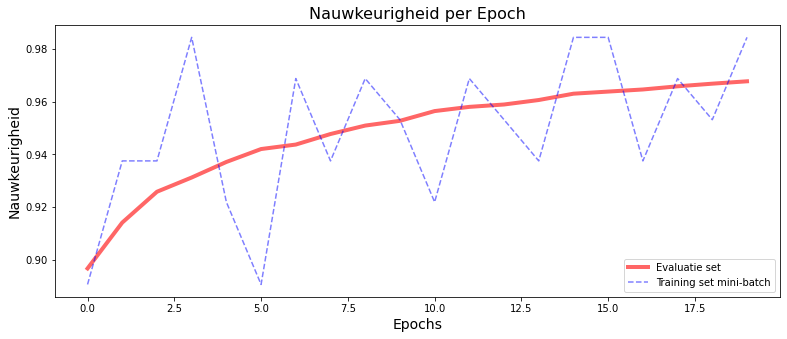

In [16]:
os.makedirs('./imgs', exist_ok=True)
metrics = run.get_metrics()

plt.figure(figsize = (13,5))
plt.plot(metrics['validation_acc'], 'r-', lw=4, alpha=.6)
plt.plot(metrics['training_acc'], 'b--', alpha=0.5)
plt.legend(['Evaluatie set', 'Training set mini-batch'])
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Nauwkeurigheid', fontsize=14)
plt.title('Nauwkeurigheid per Epoch', fontsize=16)
run.log_image(name='acc_over_epochs.png', plot=plt)
plt.show()

## Download

In [17]:
run.download_files(prefix='outputs/model', output_directory='./model', append_prefix=False)

## Testen

    import tensorflow as tf
    imported_model = tf.saved_model.load('./model')

    pred = imported_model(X_test)
    y_hat = np.argmax(pred, axis=1)

    # print the first 30 labels and predictions
    print('labels:  \t', y_test[:30])
    print('predictions:\t', y_hat[:30])
    
    print("Accuracy on the test set:", np.average(y_hat == y_test))